# <u>Yelp Rating Prediction Using Tensorflow</u>

## **Modeling (sigmoid and adam):**

### *Libraries*

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

#import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
#import sys
#import sklearn as sk
import pandas as pd
import os
import sklearn.feature_extraction.text as sk_text
#import re

from collections.abc import Sequence
from sklearn import preprocessing
#import shutil
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense#, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics as mt

### *Functions*

In [2]:
# from labs

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True, sample_size=100, figsize=(15,10), title='Lift Chart, Random Sample'):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    if len(t) > sample_size:
        t = t.sample(sample_size, random_state=42)
    plt.figure(figsize=figsize)
    plt.title(title)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    
def review(model, num):
    #Turning business data into usable data for the model to predict
    business = pd.read_csv('./business_data/df_business{}_reviews_processed.csv'.format(num))
    average_stars = pd.read_csv('./business_data/df_five_businesses_info.csv')
    average_stars = average_stars['stars'].iloc[num-1]

    vectorizer = sk_text.TfidfVectorizer(min_df=.01, max_df=.99, max_features=350, dtype=np.float32) # can adjust max_features if encounter memory issues; dtype to reduce memory usage -> defaults to float64
    corpus = business['processed_text']                                         # put preprocessed text into corpus
    matrix = vectorizer.fit_transform(corpus)                                # fit and transform the corpus
    tfidf_data = matrix.toarray()              # convert matrix to array
    

    # Predicting the data
    business_predictions = model.predict(tfidf_data)

    #Displaying data:
    business_predicted = np.argmax(business_predictions, axis=1)
    predicted_rating = pd.DataFrame(business_predicted, columns=['Predicted Stars'])
    result = pd.concat([business['stars'], predicted_rating], axis=1)
    mean = predicted_rating['Predicted Stars'].mean()
    print(mean)
    print('Average predicted rating was {}, and the actual rating was {}'.format(mean, average_stars))
    accuracy = mt.accuracy_score(business['stars'], predicted_rating)
    print("Accuracy score: {}".format(accuracy))
    score = np.sqrt(mt.mean_squared_error(predicted_rating, business['stars']))
    print('RMSE: {}'.format(score))
    print('The table with predicted and actual ratings: \n{}'.format(result))

### *Load dataframe from file*

In [3]:
df = pd.read_csv("./data/df_data.csv")
df.head()

,stars,able,absolutely,actually,almost,also,always,amazing,another,anything,...,wing,without,wonderful,wont,work,worth,would,wrong,year,youre
0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.168147,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262300,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128253,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.090665,0.000000,0.0,0.0
4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.129936,...,0.0,0.0,0.0,0.0,0.0,0.118585,0.000000,0.141233,0.0,0.0


### *Use dataframe to configure x, y*

In [4]:
x, y = to_xy(df, 'stars')

### *x info*

In [5]:
print('shape:', x.shape)
print(x)

shape: (6146631, 350)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### *y info*

In [6]:
print('shape:', y.shape)
print(y)

shape: (6146631, 5)
[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


### *Separate test and train sets*

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

### *Train model*

In [8]:


# create sequential model
model = Sequential()
model.add(Dense(350, input_dim=x.shape[1], activation='sigmoid'))
model.add(Dense(177, activation='sigmoid'))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')

checkpointer = ModelCheckpoint(filepath="dnn/sigmoid_adam_best_weights.hdf5", verbose=0, save_best_only=True)

model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=10)



Epoch 1/10

153666/153666 - 686s - loss: 0.0975 - val_loss: 0.0959 - 686s/epoch - 4ms/step
Epoch 2/10


c:\Users\andre\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


153666/153666 - 687s - loss: 0.0949 - val_loss: 0.0941 - 687s/epoch - 4ms/step
Epoch 3/10
153666/153666 - 691s - loss: 0.0935 - val_loss: 0.0933 - 691s/epoch - 4ms/step
Epoch 4/10
153666/153666 - 736s - loss: 0.0925 - val_loss: 0.0928 - 736s/epoch - 5ms/step
Epoch 5/10
153666/153666 - 704s - loss: 0.0919 - val_loss: 0.0925 - 704s/epoch - 5ms/step
Epoch 6/10
153666/153666 - 704s - loss: 0.0914 - val_loss: 0.0924 - 704s/epoch - 5ms/step
Epoch 6: early stopping


### *Load best model*

In [9]:
# skip if you want to see current model results
#print('Training finished...Loading the best model')
#model.load_weights('dnn/sigmoid_adam_best_weights.hdf5')

### *Optional start point*

In [10]:
# if starting here:  load library, functions, load dataframe, configure x,y, and train/test split cells before running this cell
path = "./dnn/"
model = load_model(os.path.join(path, "sigmoid_adam_best_weights.hdf5"))

### *Model prediction*

In [11]:

prediction = model.predict(x_test)
print("Shape: {}".format(prediction.shape))
print(prediction)

38417/38417 [==============================] - 121s 3ms/step
Shape: (1229327, 5)
[[2.0494724e-04 2.5048801e-03 4.7062166e-02 4.3970224e-01 5.1052570e-01]
 [5.1049393e-04 1.6083926e-02 3.1391594e-01 6.1712313e-01 5.2366484e-02]
 [9.6951449e-01 2.5979998e-02 2.2420769e-03 7.1847707e-04 1.5450309e-03]
 ...
 [9.2577823e-02 2.5662583e-01 3.6243245e-01 2.5402957e-01 3.4334294e-02]
 [3.5682698e-03 2.2050599e-03 4.1485638e-03 6.0560118e-02 9.2951798e-01]
 [5.0977951e-01 3.9607029e-02 1.7588036e-02 4.4566132e-02 3.8845932e-01]]


## **Results:**

### *Predictions vs. Actual*

In [12]:
predicted_stars = np.argmax(prediction, axis=1)
true_stars = np.argmax(y_test, axis=1)
print("Predictions: {}".format(predicted_stars))
print("Actual: {}".format(true_stars))

Predictions: [4 3 0 ... 2 4 0]
Actual: [4 2 0 ... 0 4 0]


### *Accuracy*

In [13]:
accuracy = mt.accuracy_score(true_stars, predicted_stars)
print("Accuracy score: {}".format(accuracy))

Accuracy score: 0.6461380901908117


### *Precision*

In [14]:
precision = mt.precision_score(true_stars, predicted_stars, average="weighted")
print("Precision score: {}".format(precision))


Precision score: 0.6215145407765509


### *Recall score*

In [15]:
recall = mt.recall_score(true_stars, predicted_stars, average="weighted")
print("Recall score: {}".format(recall))

Recall score: 0.6461380901908117


### *F1 score*

In [16]:
f1 = mt.f1_score(true_stars, predicted_stars, average="weighted")
print("F1 score: {}".format(f1))

F1 score: 0.627268341698795


### *Log score*

In [17]:
log_score = mt.log_loss(y_test, prediction)
print("Log loss score: {}".format(log_score))

Log loss score: 0.8530703177357987


### *Classification report*

In [18]:
print(mt.classification_report(true_stars, predicted_stars))

              precision    recall  f1-score   support

           0       0.67      0.79      0.73    172632
           1       0.43      0.21      0.28     98018
           2       0.45      0.31      0.37    127331
           3       0.49      0.45      0.47    268156
           4       0.74      0.85      0.79    563190

    accuracy                           0.65   1229327
   macro avg       0.55      0.52      0.53   1229327
weighted avg       0.62      0.65      0.63   1229327



### *Mean Squared Error (MSE)*

In [19]:
mse = mt.mean_squared_error(prediction, y_test)
print('Final score (MSE): {}'.format(mse))


Final score (MSE): 0.09232444316148758


### *Root Mean Squared Error (RMSE)*

In [20]:
score = np.sqrt(mt.mean_squared_error(prediction, y_test))
print('Final score (RMSE): {}'.format(score))

Final score (RMSE): 0.30384936928749084


### *Actual vs. predicted*

In [21]:
df_y = pd.DataFrame(true_stars, columns=['actual'])
df_pred = pd.DataFrame(predicted_stars, columns=['predicted'])
result = pd.concat([df_y, df_pred], axis=1)
result

,actual,predicted
0,4,4
1,2,3
2,0,0
3,3,4
4,2,3
...,...,...
1229322,3,2
1229323,3,4
1229324,0,2
1229325,4,4


### *Regression lift chart*

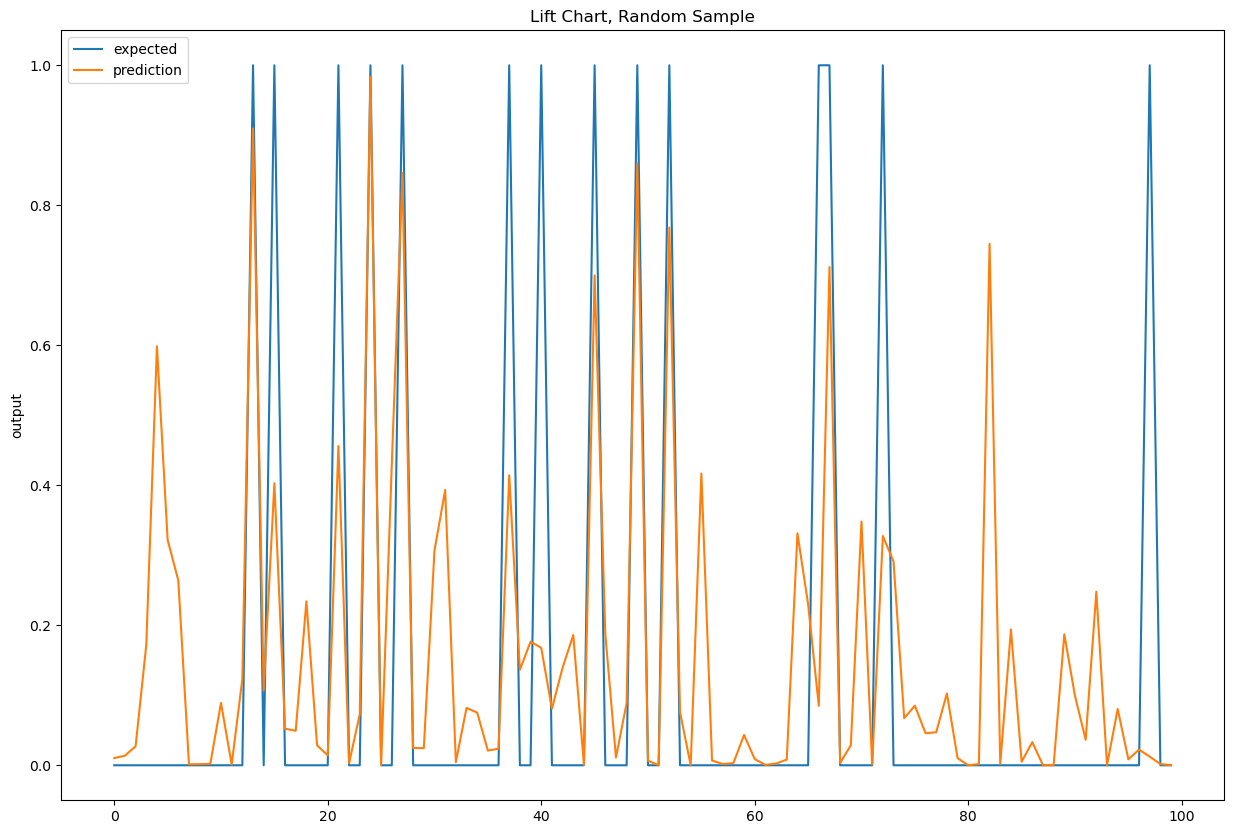

In [22]:
chart_regression(prediction.flatten(), y_test, sort=True)

## **Comparing Predictions to Business Reviews**

### *Information for businesses used with model*

In [2]:
df = pd.read_csv("./business_data/df_five_businesses_info.csv")
print(df)

              business_id                       name  stars  review_count  \
0  Jv8lYSZPxY0rzkSpgo7BIw  Big Boyz Burgers and More    4.0            22   
1  7k9qGQyytbGxpJTnwxK6Xg         QDOBA Mexican Eats    3.0            40   
2  v_vqna00z6WqKcIJZDkbAw                    C Nails    4.5            61   
3  zsQ1_PNV3KN0EWhAE-WV9g  Tohono Chul Garden Bistro    4.0           165   
4  v2L2HnZzYvHPgFcVBg2TUw             Summerland Inn    2.0            56   

                                          categories  
0  American (Traditional), Diners, Breakfast & Br...  
1  Restaurants, Event Planning & Services, Mexica...  
2   Waxing, Hair Removal, Nail Salons, Beauty & Spas  
3  American (New), Venues & Event Spaces, Restaur...  
4  Hotels, Hotels & Travel, Bed & Breakfast, Even...  


### *Big Boys Burgers and More*

In [23]:
review(model, 1)

1/1 [==============================] - 0s 125ms/step
3.5217391304347827
Average predicted rating was 3.5217391304347827, and the actual rating was 4.0
Accuracy score: 0.17391304347826086
RMSE: 1.5463842820677165
The table with predicted and actual ratings: 
    stars  Predicted Stars
0       5                4
1       4                0
2       5                3
3       5                4
4       5                3
5       5                4
6       5                4
7       5                4
8       3                4
9       4                4
10      4                4
11      5                4
12      5                4
13      5                4
14      4                4
15      1                3
16      2                4
17      3                1
18      2                3
19      4                4
20      2                4
21      3                4
22      2                4


### *QDOBA Mexican Eats*

In [24]:
review(model, 2)

2/2 [==============================] - 0s 9ms/step
2.925
Average predicted rating was 2.925, and the actual rating was 3.0
Accuracy score: 0.125
RMSE: 1.8027756377319946
The table with predicted and actual ratings: 
    stars  Predicted Stars
0       5                4
1       2                2
2       5                0
3       5                4
4       2                0
5       2                4
6       3                4
7       5                4
8       4                4
9       2                1
10      1                0
11      5                4
12      3                3
13      4                3
14      4                0
15      5                3
16      3                2
17      3                4
18      1                4
19      1                4
20      3                1
21      1                2
22      1                4
23      4                3
24      3                4
25      2                1
26      1                3
27      4                3
2

### *C Nails*

In [25]:
review(model, 3)

2/2 [==============================] - 0s 11ms/step
2.8548387096774195
Average predicted rating was 2.8548387096774195, and the actual rating was 4.5
Accuracy score: 0.016129032258064516
RMSE: 2.5809475629273533
The table with predicted and actual ratings: 
    stars  Predicted Stars
0       5                4
1       1                0
2       5                0
3       5                0
4       5                0
..    ...              ...
57      1                4
58      4                3
59      5                0
60      4                3
61      5                4

[62 rows x 2 columns]


### *Tohono Chul Garden Bistro*

In [26]:
review(model, 4)

6/6 [==============================] - 0s 7ms/step
3.1264367816091956
Average predicted rating was 3.1264367816091956, and the actual rating was 4.0
Accuracy score: 0.20114942528735633
RMSE: 1.6400168207716022
The table with predicted and actual ratings: 
     stars  Predicted Stars
0        3                3
1        4                3
2        5                3
3        3                0
4        5                4
..     ...              ...
169      5                3
170      5                3
171      4                3
172      1                0
173      5                4

[174 rows x 2 columns]


### *Summerland Inn*

In [27]:
review(model, 5)

2/2 [==============================] - 0s 9ms/step
2.706896551724138
Average predicted rating was 2.706896551724138, and the actual rating was 2.0
Accuracy score: 0.06896551724137931
RMSE: 2.296924480466329
The table with predicted and actual ratings: 
    stars  Predicted Stars
0       1                2
1       1                4
2       5                0
3       3                4
4       5                0
5       1                2
6       4                3
7       1                2
8       1                4
9       1                2
10      1                4
11      4                3
12      1                4
13      1                1
14      1                4
15      1                3
16      1                0
17      4                3
18      1                3
19      4                3
20      3                1
21      3                3
22      4                2
23      1                3
24      1                0
25      1                0
26      2         